# University of Mannheim
## Data Mining I -- Group Project
### Wine Quality Prediction with SVM
#### Team members:
* Anna-Lena Blinken
* Max Darmstadt
* Nicolas Hautschek
* Erik Penther
* Nicolas Fürhaupter

## Importing Libraries and Data

In [1]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

In [2]:
# Import libraries

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Libraries for the preprocessing
from sklearn.model_selection import train_test_split

# Liraries for the model creation
from sklearn import svm  
from sklearn.pipeline import Pipeline

# Libraries for the evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import itertools

# Libraries for the model adaption
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE 
from collections import Counter
from sklearn.inspection import permutation_importance
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

In [3]:
# Import wine data

wine_data = pd.read_csv('./winequalityN.csv')
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Visualize and Analyse Data

In [4]:
# Print wine data info

wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
# Analyse the data by its mean etc.

wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Null Values

In [6]:
# Check data for null values

wine_data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [7]:
# Check class distribution

wine_data.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

### Class Distribution

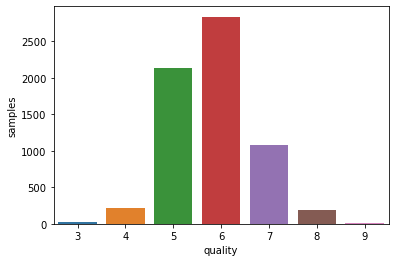

In [8]:
# Visualize class distribution

sns.barplot(x=wine_data.quality.value_counts().index, y=wine_data.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

In [9]:
# Turn 10 classes into 3 classes

wine_data['quality'] = wine_data.quality.apply(lambda x: 2 if x>6 else (1 if x> 4 else 0))

In [10]:
# Check class distribution

wine_data.quality.value_counts()

1    4974
2    1277
0     246
Name: quality, dtype: int64

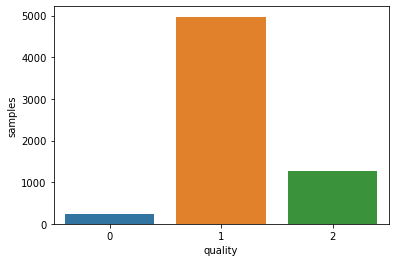

In [11]:
# Visualize class distribution

sns.barplot(x=wine_data.quality.value_counts().index, y=wine_data.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

In [12]:
# Turn 10 classes into 2 classes

wine_data_2 = pd.read_csv('./winequalityN.csv')
wine_data_2['quality'] = wine_data_2.quality.apply(lambda x: 2 if x>5 else 0)

In [13]:
# Check class distribution

wine_data_2.quality.value_counts()

2    4113
0    2384
Name: quality, dtype: int64

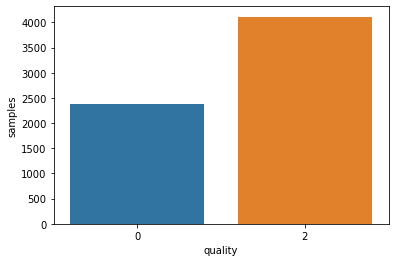

In [14]:
# Visualize class distribution

sns.barplot(x=wine_data_2.quality.value_counts().index, y=wine_data_2.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

### Check duplicates

In [15]:
# Count duplicates and remove duplicates

display(len(wine_data.index))
wine_data.drop_duplicates()
display(len(wine_data.index))

6497

6497

### Unique Values

In [16]:
# Count uniques values of each column

wine_data.nunique()

type                      2
fixed acidity           106
volatile acidity        187
citric acid              89
residual sugar          316
chlorides               214
free sulfur dioxide     135
total sulfur dioxide    276
density                 998
pH                      108
sulphates               111
alcohol                 111
quality                   3
dtype: int64

### Distribution of Values

<AxesSubplot:>

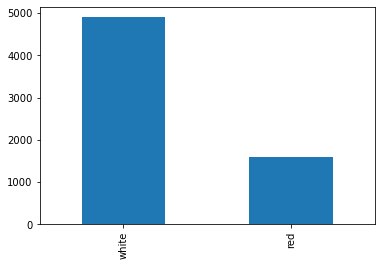

In [17]:
# Plot histogram for each categorical column

wine_data['type'].value_counts().plot(kind='bar')

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

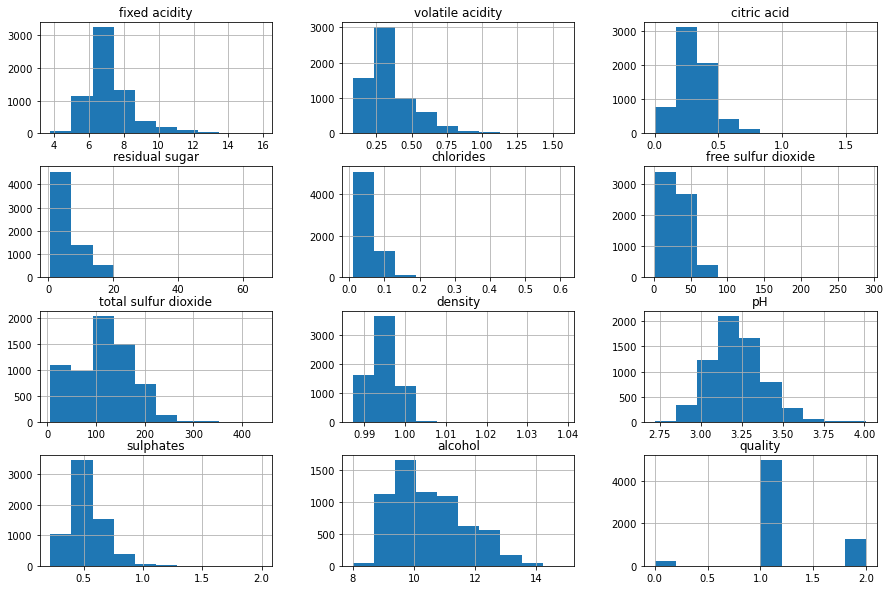

In [18]:
# Plot histogram for each numerical column

wine_data.hist(figsize=(15, 10))

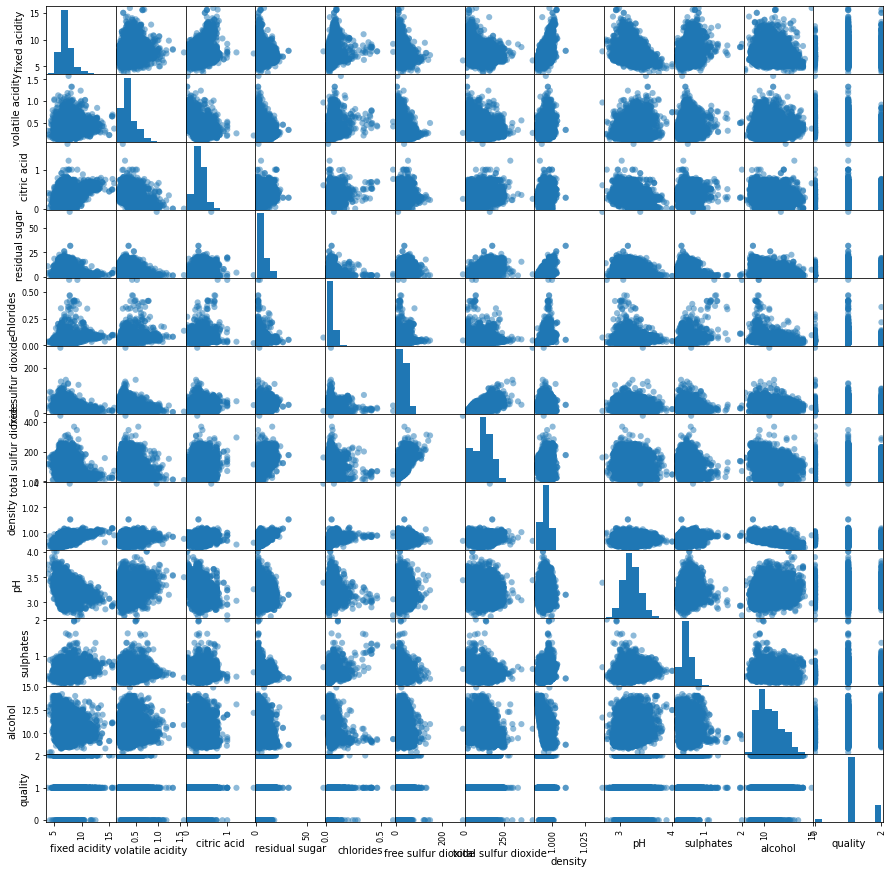

In [19]:
# Plot scatterplots for all possible combinations of columns

pd.plotting.scatter_matrix(wine_data, figsize=(15, 15), s=150);

## Data Cleaning

In [20]:
# Delete null-values 

wine_data = wine_data.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)
display(wine_data.isnull().sum())
display(len(wine_data.index))

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

6463

In [21]:
# Ordinal Encoder for the attribute type

# Show data before preprocessing
display(wine_data.head())

# Create the OrdinalEncoder
ordinal_encoder = preprocessing.OrdinalEncoder()

# Preprocess the categorical feature type
wine_data[['type']] = ordinal_encoder.fit_transform(wine_data[['type']])

# Show the results
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,1.0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [22]:
# Normalisation of the numerical values

# Show data before preprocessing
display(wine_data.head())

# Create the normaliser
scaler = preprocessing.MinMaxScaler()

# Preprocess the all numerical features
wine_data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']] = scaler.fit_transform(wine_data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']])

# Show the results
display(wine_data.head())

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,1.0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,1
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,1
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,1
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,1
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,1


In [23]:
# Deleting outliers from the dataset

# Defining columns for the outlier detection (type and quality are not included)
wine_data_columns = ['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

# Identify outliers
for x in wine_data_columns:
    for y in x:
        q95,q05 = np.percentile(wine_data.loc[:,x],[95,5])
        intr_qr = q95-q05

        max = q95+(1.5*intr_qr)
        min = q05-(1.5*intr_qr)

        wine_data.loc[wine_data[x] < min,x] = np.nan
        wine_data.loc[wine_data[x] > max,x] = np.nan
        
display(wine_data.isnull().sum())

# Drop outliers
wine_data = wine_data.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)
display(wine_data.isnull().sum())
display(len(wine_data.index))

type                     0
fixed acidity            0
volatile acidity         1
citric acid              1
residual sugar           1
chlorides               47
free sulfur dioxide      2
total sulfur dioxide     0
density                  1
pH                       0
sulphates                8
alcohol                  0
quality                  0
dtype: int64

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

6406

## Seperation of features and the target variable and test train split

In [24]:
# Seperation of features and the target variable in two different data frames

wine_data = wine_data.copy()

features = wine_data.drop(columns='quality')
display(features.head())

target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
display(target.head())
target = target['quality'].ravel()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362


,quality
0,1
1,1
2,1
3,1
4,1


In [25]:
# Train test split

data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

## Support Vector Machine (SVM)


In [26]:
# Model Creation

# Create svm classifier and pipeline
support_vector_machine = svm.SVC()
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

### Evaluation

In [27]:
# Predict values for the test data

predictions_test_svm = pipeline_svm.predict(data_test)

#### Makro F1-Score, Makro Precision, and Makro Recall 

In [28]:
# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

Makro F1-Score Train Data:


0.3841761149022285

Makro F1-Score Test Data:


0.4123654606537148

Makro Precision Train Data:


0.4918004059173445

Makro Precision Test Data:


0.5028778097534418

Makro Recall Train Data:


0.38482706665476724

Makro Recall Test Data:


0.4048910935062781

#### Confusion Matrix

In [29]:
# Function to plot a confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion Matrix Train Data:


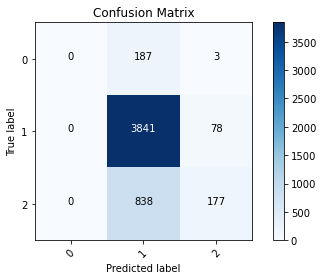

In [30]:
# Confusion Matrix for the training data

cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2]))

Confusion Matrix Test Data:


None

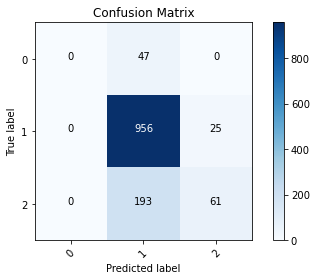

In [31]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

## Adoption of the Mode

1. First Hyperparameter Tuning
2. Oversampling (Balancing)
3. Feature Selection
4. Second Hyperparameter Tuning

In each step the best model, which was achieved until that stage, is utilized.

### First Hyperparameter Tuning

- usual parameters to optimize:
  - choice of kernel: `linear`, `rbf`, ...
  - C (Regularization parameter)
  - gamma (Kernel coefficient) for `rbf`

In [32]:
# Create an estimator
support_vector_machine = svm.SVC()

# Specify the parameter grid
param_grid = [
  {'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000, 10000], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000, 10000], 'gamma': [1, 0.1, 0.01], 'kernel': ['poly']},
  {'C': [1, 10, 100, 1000, 10000], 'gamma': [1, 0.1, 0.01], 'kernel': ['sigmoid']},
 ]

# Specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the grid search instance
grid_search_estimator_svm = GridSearchCV(support_vector_machine, param_grid, scoring='f1_macro', cv=stratified_10_fold_cv, n_jobs = -1, verbose = 2, return_train_score=False)

# Run the grid search
grid_search_estimator_svm.fit(data_train, target_train)

# Print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator_svm.cv_results_)
display(results)
    
# Print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator_svm.best_score_, grid_search_estimator_svm.best_params_))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.870296,0.028622,0.077481,0.006248,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.288766,0.288766,...,0.288766,0.289086,0.289086,0.289086,0.289086,0.289086,0.288667,0.288916,0.000172,26
1,0.957031,0.043680,0.081180,0.009874,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.288766,0.288766,...,0.288766,0.289086,0.289086,0.289086,0.289086,0.289086,0.288667,0.288916,0.000172,26
2,6.973913,2.244845,0.084700,0.008575,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.288766,0.288766,...,0.288766,0.289086,0.289086,0.289086,0.289086,0.289086,0.288667,0.288916,0.000172,26
3,145.886519,11.166414,0.117268,0.033027,1000,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.288766,0.288766,...,0.288766,0.289086,0.289086,0.289086,0.289086,0.289086,0.288667,0.288916,0.000172,26
4,253.301687,11.095138,0.109280,0.018127,10000,linear,NaN,"{'C': 10000, 'kernel': 'linear'}",0.288766,0.288766,...,0.288766,0.289086,0.289086,0.289086,0.289086,0.289086,0.288667,0.288916,0.000172,26
5,1.976899,0.182953,0.434115,0.056169,1,rbf,1,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.308176,0.320158,...,0.326219,0.348520,0.355903,0.342811,0.380764,0.318621,0.336346,0.337649,0.020019,24
6,1.619618,0.048225,0.394856,0.016017,1,rbf,0.1,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.288766,0.288766,...,0.288766,0.289086,0.289086,0.289086,0.289086,0.289086,0.288667,0.288916,0.000172,26
7,1.433560,0.058365,0.392008,0.034820,1,rbf,0.01,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.288766,0.288766,...,0.288766,0.289086,0.289086,0.289086,0.289086,0.289086,0.288667,0.288916,0.000172,26
8,2.102927,0.136903,0.377365,0.033445,10,rbf,1,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.411332,0.434613,...,0.393795,0.413298,0.417444,0.441035,0.414598,0.405534,0.397379,0.416593,0.015457,12
9,1.865104,0.055637,0.371159,0.020631,10,rbf,0.1,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.288766,0.288766,...,0.288766,0.289086,0.289086,0.289086,0.289086,0.289086,0.288667,0.288916,0.000172,26


best score is 0.5415304758084347 with params {'C': 10000, 'gamma': 1, 'kernel': 'rbf'}


#### Model (SVM) with Hyperparameter Tuning

Makro F1-Score Train Data:


0.719500198554182

Makro F1-Score Test Data:


0.5750698084670779

Makro Precision Train Data:


0.8709671265614775

Makro Precision Test Data:


0.642275033654344

Makro Recall Train Data:


0.6483699658381243

Makro Recall Test Data:


0.5405282315180705

Confusion Matrix Train Data:


None

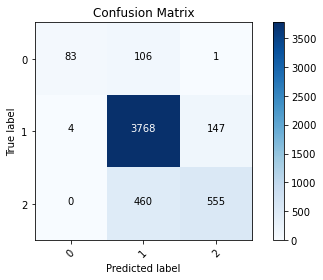

In [33]:
# Changing Hyperparameters 

# Creation of the svm classifier and the pipeline with the new parameters
support_vector_machine = svm.SVC(C=10000, kernel='rbf', gamma=1)
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

# Predict values for the test data
predictions_test_svm = pipeline_svm.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

# Confusion Matrix for the training data
cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

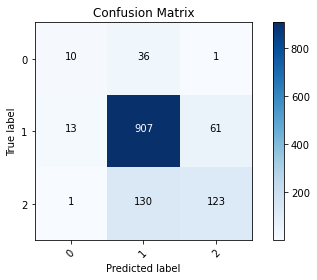

In [34]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

### Oversampling (Balancing)

On the basis of the model with the hypertuning of the parameters.

In [35]:
# Run this cell if the package is not installed
# %pip install -q -U imbalanced-learn

Original length of the train dataset (data_train):


5124

Length of target_train:


5124

Class Distribution: Counter({1: 3919, 2: 1015, 0: 190})

Length of balanced train dataset (data_train):


11757

New length of target_train:


11757

New Class Distribution: Counter({1: 3919, 2: 3919, 0: 3919})

Makro F1-Score Train Data:


0.8854780104974035

Makro F1-Score Test Data:


0.5646910105932688

Makro Precision Train Data:


0.8908169814692887

Makro Precision Test Data:


0.5384643363755851

Makro Recall Train Data:


0.888236795100791

Makro Recall Test Data:


0.677492819253537

Confusion Matrix Train Data:


None

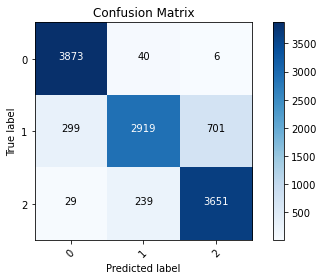

In [36]:
# We use SMOTE to synthesize new examples in the minority class of the train data from the existing examples 

# Print the class distribution before SMOTE
print('Original length of the train dataset (data_train):')
display(len(data_train.index))
print('Length of target_train:')
display(target_train.size)
print('Class Distribution: %s' % Counter(target_train))

# Oversampling 
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Print the new class distribution after SMOTE
print('\nLength of balanced train dataset (data_train):')
display(len(data_train.index))
print('New length of target_train:')
display(target_train.size)
print('New Class Distribution: %s' % Counter(target_train))

# Creation of the new svm classifier and the pipeline
support_vector_machine = svm.SVC(C=10000, kernel='rbf', gamma=1)
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

# Predict values for the test data
predictions_test_svm = pipeline_svm.predict(data_test)

# Makro F1-Score
print("\nMakro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

# Confusion Matrix for the training data
cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

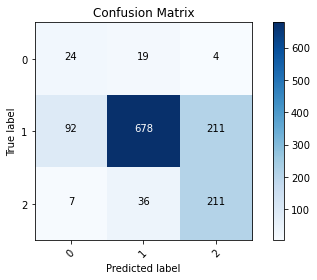

In [37]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

### Important Note

Although the svm model performance decreased by ~0,01 (Makro F1-Score - Test Data) and ~0,10 (Makro Precision - Test Data) after oversampling, we will still select this model for the next steps (feature selection and the second hyperparameter tuning with some adaptions). This is because of three reasons: 

- The Makro Recall metric in the oversampled model increased significantly (~0,14) and the F1-Score (our main evaluation metric) remained almost unchanged (see above).
    
- In the oversampled model, the predictions for classes 0 and 2 became much more accurate (see confusion matrix).
        
- The model previous to oversampling had a heavy tendency/bias to class 1 in the test data (see confusion matrix) due to the unbalanced training dataset. This led to the high evaluation metrics of the unbalanced test dataset as well. We want to avoid such bias and keep the model close to the real practice. We do not know if wines outside of our dataset will also mostly fall into the medium category (class 1).  

### Feature Selection

On the basis of the model with the hypertuning of the parameters and the oversampling.

Due to the rbf kernel, the calculation of the feature importance is not possible. 

Text(0.5, 0, 'Permutation Importance')

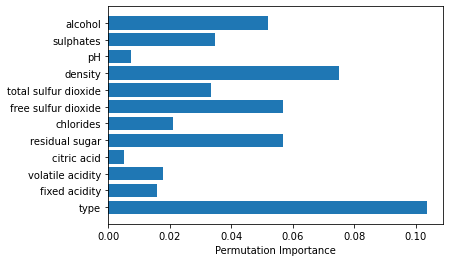

In [38]:
# Permutation Importance

perm_importance = permutation_importance(support_vector_machine, data_test, target_test)
feature_list = list(features)
plt.barh(feature_list, perm_importance.importances_mean)
plt.xlabel("Permutation Importance")

In [39]:
# Feature Correlation

wines = wine_data.copy()
y_ql = wines.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # Get Y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

    # Calculate VIF factors: for each X, calculate VIF and save it in the dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols

vif = VRF('quality', df.loc[:, cols], y_ql)

,VIF Factor,features
0,1.000000,Intercept
13,1.243562,quality
11,1.559567,sulphates
4,1.617980,citric_acid
6,1.969709,chlorides
3,2.219198,volatile_acidity
7,2.253225,free_sulfur_dioxide
10,2.740514,pH
8,4.037936,total_sulfur_dioxide
2,5.750609,fixed_acidity


#### Feature Permutation: Model without citric acid

,type,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,0.264463,0.126667,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942
1,1.0,0.206612,0.146667,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391
2,1.0,0.355372,0.133333,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348
3,1.0,0.280992,0.100000,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362
4,1.0,0.280992,0.100000,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362



Makro F1-Score Train Data:


0.864443185629022

Makro F1-Score Test Data:


0.5610690664811161

Makro Precision Train Data:


0.8705482028967054

Makro Precision Test Data:


0.5365152158424346

Makro Recall Train Data:


0.8682487029003997

Makro Recall Test Data:


0.7027601322428879

Confusion Matrix Train Data:


None

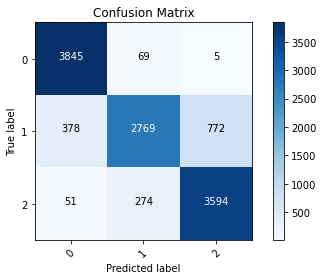

In [40]:
# Seperation of features and the target variable in two different data frames and dropping the columns quality and citric acid
features = wine_data.drop(columns=['quality', 'citric acid'])
display(features.head())
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Creation of the svm classifier and the pipeline
support_vector_machine = svm.SVC(C=10000, kernel='rbf', gamma=1)
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

# Predict values for the test data
predictions_test_svm = pipeline_svm.predict(data_test)

# Makro F1-Score
print("\nMakro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

# Confusion Matrix for the training data
cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

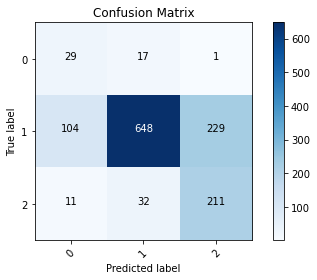

In [41]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

#### Feature Correlation:  Model without fixed acidity, alcohol, type, residual sugar, and density

,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates
0,0.126667,0.216867,0.059801,0.152778,0.377880,0.217054,0.129213
1,0.146667,0.204819,0.066445,0.045139,0.290323,0.449612,0.151685
2,0.133333,0.240964,0.068106,0.100694,0.209677,0.418605,0.123596
3,0.100000,0.192771,0.081395,0.159722,0.414747,0.364341,0.101124
4,0.100000,0.192771,0.081395,0.159722,0.414747,0.364341,0.101124



Makro F1-Score Train Data:


0.749344010174107

Makro F1-Score Test Data:


0.4770260985059053

Makro Precision Train Data:


0.7561984719779905

Makro Precision Test Data:


0.4877107132161041

Makro Recall Train Data:


0.757080887981628

Makro Recall Test Data:


0.6605274607444841

Confusion Matrix Train Data:


None

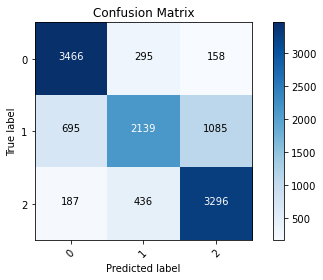

In [42]:
# Seperation of features and the target variable in two different data frames and dropping the columns fixed acidity, alcohol, type, residual sugar, and density
features = wine_data.drop(columns=['quality', 'type', 'fixed acidity', 'alcohol', 'density', 'residual sugar'])
display(features.head())
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Creation of the svm classifier and the pipeline
support_vector_machine = svm.SVC(C=10000, kernel='rbf', gamma=1)
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

# Predict values for the test data
predictions_test_svm = pipeline_svm.predict(data_test)

# Makro F1-Score
print("\nMakro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

# Confusion Matrix for the training data
cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

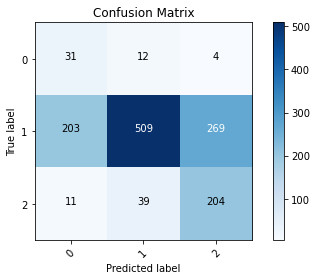

In [43]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

### Note

After implementing the Feature Permutation and Feature Correlation, the evaluation metrics could not be further improved. Therefore, we will use the balanced model without dropping any columns or irrelevant attributes for the second hyperparameter tuning. 

### Second Hyperparameter Tuning

In [44]:
# Seperation of features and the target variable in two different data frames
features = wine_data.drop(columns=['quality'])
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create an estimator
support_vector_machine = svm.SVC()

# Specify the parameter grid
# Due to performance issues, the hyperparameter 'C' = 10000 was left out for 'kernel' = 'poly'
param_grid = [
  {'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000, 10000], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01], 'kernel': ['poly']},
  {'C': [1, 10, 100, 1000, 10000], 'gamma': [1, 0.1, 0.01], 'kernel': ['sigmoid']},
 ]

# Specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the grid search instance
grid_search_estimator_svm = GridSearchCV(support_vector_machine, param_grid, scoring='f1_macro', cv=stratified_10_fold_cv, n_jobs = -1, verbose = 2, return_train_score=False)

# Run the grid search
grid_search_estimator_svm.fit(data_train, target_train)

# Print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator_svm.cv_results_)
display(results)
    
# Print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator_svm.best_score_, grid_search_estimator_svm.best_params_))

Fitting 10 folds for each of 47 candidates, totalling 470 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,14.650099,1.600250,1.222141,0.173879,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.644670,0.638774,...,0.646987,0.647041,0.631495,0.650452,0.639394,0.631890,0.661270,0.642126,0.009441,24
1,20.819217,1.289723,1.432041,0.265094,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.646677,0.641100,...,0.650015,0.647362,0.639620,0.647177,0.636489,0.629914,0.665610,0.643544,0.009844,23
2,32.027841,2.900523,1.135288,0.182932,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.653994,0.642788,...,0.647630,0.644661,0.639566,0.649553,0.631895,0.629093,0.663088,0.643602,0.010010,20
3,58.239659,3.581666,0.834204,0.063628,1000,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.653117,0.645499,...,0.650056,0.646527,0.637850,0.651529,0.630158,0.629030,0.662110,0.643900,0.010415,18
4,285.350404,7.802091,0.827277,0.046628,10000,linear,NaN,"{'C': 10000, 'kernel': 'linear'}",0.653069,0.642791,...,0.649362,0.644795,0.638796,0.652266,0.634365,0.627147,0.659331,0.643635,0.009544,19
5,13.953441,0.721560,3.138205,0.282774,1,rbf,1,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",0.708011,0.695603,...,0.682911,0.693375,0.690947,0.695303,0.687730,0.666880,0.690860,0.687792,0.012247,12
6,21.037849,2.196637,4.335408,0.438363,1,rbf,0.1,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.645229,0.657273,...,0.636660,0.644542,0.631010,0.635693,0.635228,0.636157,0.655915,0.640131,0.010082,27
7,27.576036,1.393681,5.204595,0.518052,1,rbf,0.01,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.613991,0.623524,...,0.600387,0.617311,0.595209,0.595883,0.600830,0.605441,0.619494,0.606576,0.010519,33
8,14.848972,1.641547,3.095572,0.344473,10,rbf,1,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",0.750618,0.733351,...,0.724146,0.733959,0.738201,0.731028,0.722218,0.717539,0.727459,0.729448,0.009854,8
9,14.904121,0.953149,3.273000,0.288553,10,rbf,0.1,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.660725,0.653896,...,0.656485,0.660954,0.654959,0.649423,0.654071,0.647911,0.665967,0.653587,0.008985,17


best score is 0.8507682285312246 with params {'C': 10000, 'gamma': 1, 'kernel': 'rbf'}


#### Model (SVM) with Hyperparameter Tuning (1)

There wasn't any change in the result because the optimal combination of hyperparameters remained the same as above. 

Makro F1-Score Train Data:


0.8854780104974035

Makro F1-Score Test Data:


0.5646910105932688

Makro Precision Train Data:


0.8908169814692887

Makro Precision Test Data:


0.5384643363755851

Makro Recall Train Data:


0.888236795100791

Makro Recall Test Data:


0.677492819253537

Confusion Matrix Train Data:


None

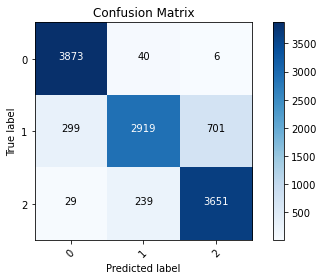

In [45]:
# Changing Hyperparameters 

# Creation of the svm classifier and the pipeline with the new parameters
support_vector_machine = svm.SVC(C=10000, kernel='rbf', gamma=1)
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

# Predict values for the test data
predictions_test_svm = pipeline_svm.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

# Confusion Matrix for the training data
cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

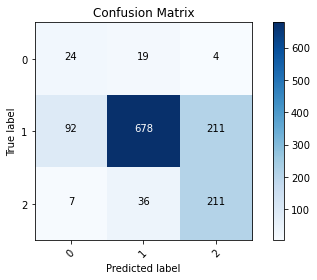

In [46]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

#### Model (SVM) with Hyperparameter Tuning (2)

Another model was created for further experimentation with the hyperparameters C and gamma.

Makro F1-Score Train Data:


0.9350550906121518

Makro F1-Score Test Data:


0.5761093749465842

Makro Precision Train Data:


0.9383559793521811

Makro Precision Test Data:


0.5469696512731426

Makro Recall Train Data:


0.935953049247257

Makro Recall Test Data:


0.6567780798823142

Confusion Matrix Train Data:


None

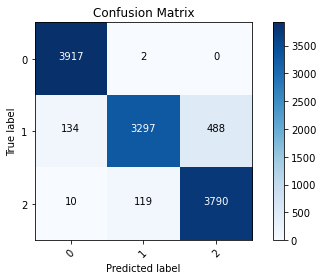

In [53]:
# Changing Hyperparameters 

# Creation of the svm classifier and the pipeline with the new parameters
support_vector_machine = svm.SVC(C=10000, kernel='rbf', gamma=2)
pipeline_svm = Pipeline([('estimator', support_vector_machine)])

# Fit the model and predict the values for the train data
pipeline_svm.fit(data_train, target_train)
predictions_train_svm = pipeline_svm.predict(data_train)

# Predict values for the test data
predictions_test_svm = pipeline_svm.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_svm = f1_score(target_train, predictions_train_svm, average='macro')
display(f1_score_train_svm)

print("Makro F1-Score Test Data:")
f1_score_test_svm = f1_score(target_test, predictions_test_svm, average='macro')
display(f1_score_test_svm)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_svm = precision_score(target_train, predictions_train_svm, average='macro', zero_division = 0)
display(precision_train_svm)

print("Makro Precision Test Data:")
precision_test_svm = precision_score(target_test, predictions_test_svm, average='macro', zero_division = 0)
display(precision_test_svm)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_svm = recall_score(target_train, predictions_train_svm, average='macro')
display(recall_train_svm)

print("Makro Recall Test Data:")
recall_test_svm = recall_score(target_test, predictions_test_svm, average='macro')
display(recall_test_svm)

# Confusion Matrix for the training data
cnf_matrix_train_svm = confusion_matrix(target_train, predictions_train_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_svm, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

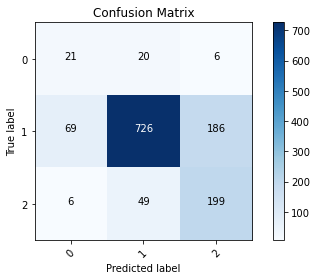

In [54]:
# Confusion Matrix for the test data

cnf_matrix_test_svm = confusion_matrix(target_test, predictions_test_svm)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_svm, classes=np.array([0,1,2])))

### Conclusion

After further experimentation with the hyperparameters 'C' and 'gamma', the best model regarding the Makro F1-Score could be generated. This model is based on the balanced dataset with no feature selection and was tuned with the second hyperparameter tuning. The Makro F1-Score for the train data is 93.5 %, for the test data it is 57.6 %. In theory, it is possible to further increase the Makro F1-Score for the test data to values above 60 % by increasing the hyperparameters 'C' and 'gamma'. However, this would lead to an even higher overfit-tendency of the model. Therefore, this step was avoided.  